#Introducción
---
TFM: Aplicación de ciencia de datos en el sector de producción animal para la predicción y explicación de óptimos en ganado porcino.

*Titulo*: **LGBMRegressor**

*Autor*: **Jose Eduardo Cámara Gómez**

---

## Importar paquetes

In [1]:
# Importación de paquetes
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
from matplotlib.pyplot import figure

from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

from sklearn.ensemble import HistGradientBoostingRegressor

sns.set(style="darkgrid")

In [2]:
from google.colab import files
# Cargamos el fichero del dataset gmd_02.csv
uploaded = files.upload()
# Leemos el fichero csv con los datos
df = pd.read_csv('gmd_02.csv', sep=';')
# Revisar la raza si se agrupan las razas con menos ocurrencias
agrupar_razas = {93 : 93, 85 : 93, 90 : 93, 95 : 93, 94 : 93, 82 : 93, 80 : 80, 96 : 80, 88 : 88, 0 : 0, 23 : 0,
                 84 : 0, 66 : 0, 18 : 0, 68 : 88, 7 : 7, 89 : 7, 65 : 7, 15 : 15, 97 : 7, 69 : 69, 81 : 81}
df.replace({'ct_raza' : agrupar_razas}, inplace=True)
df["bajas"] = df["NumBajas"] / (df["NumAnimales"] * df["DiasMedios"])
# Convertimos los tipos
df["ct_integra"] = df["ct_integra"].astype("category")
#df["ct_tipo"] = df["ct_tipo"].astype("category")
df["ct_raza"] = df["ct_raza"].astype("category")
df["ct_fase"] = df["ct_fase"].astype("category")
df['EntradaInicial']= pd.to_datetime(df['EntradaInicial'])
df['EntradaFinal']= pd.to_datetime(df['EntradaFinal'])
df["na_rega"] = df["na_rega"].astype("category")
df["NumBajas"] = df["NumBajas"].astype("int64")
df["gr_codpos"] = df["gr_codpos"].astype("category")
df["gr_poblacion"] = df["gr_poblacion"].astype("category")
df["na_nombre2"] = df["na_nombre2"].astype("category")

# Funcion para convertir en One Hot Encoding
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res)
# Cargamos las variables objetivo y las usadas (15 variables seleccionadas, una de ellas categórica con 8 valores).
y = df['GMD']
x0 = df[['ct_integra','ct_tipo', 'ct_raza', 'IncPeso', 'NumAnimales', 'na_rega', 
         'PesoEntMedio', 'PesoRecMedio', 'bajas', 'GPS_Longitud', 'GPS_Latitud', 
         'semanaEntrada', 'añoEntrada', 'PorcHembras', 'PiensoCerdaDia']]
features_to_encode = ['ct_raza']   # , 'na_rega']
x1 = x0.copy()
x1.drop(['ct_integra','na_rega'], inplace=True, axis=1)
for feature in features_to_encode:
    x1 = encode_and_bind(x1, feature)

Saving gmd_02.csv to gmd_02.csv


In [3]:
X_train, X_test, y_train, y_test = train_test_split(x1, y, test_size = 0.2, random_state = 123)
# Vemos de escalar las variables para que no se vean influenciadas por los outliers.
scaler = RobustScaler()
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

In [6]:
import lightgbm as lgb

# Definiendo parámetros del Modelo 
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 200,
    'learnnig_rage': 0.01,
    'metric': None,
    'verbose': -100
}

# Cargando Datos
lgb_train = lgb.Dataset(X_train_s, y_train, silent=True)
lgb_eval = lgb.Dataset(X_test_s, y_test, reference=lgb_train, silent=True)

# Ajustando el modelo
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 num_boost_round=20000,
                 early_stopping_rounds=500,
                 verbose_eval=-100)

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] Unknown parameter: learnnig_rage
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[70]	valid_0's l2: 0.00114773


In [7]:
# Analizamos otros errores del método
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import max_error
y_pred = model.predict(X_test_s)
# Definimos la función con las métricas a mostrar
def mostrar_metricas(y_test, y_pred):
   print("Metr.\t Valor\t\t\t Descripción")
   print("R^2 \t", r2_score(y_test, y_pred), "\t (Coeficiente de Determinación)")
   print("RMSE\t", mean_squared_error(y_test, y_pred, squared=True), "\t (Raíz de error cuadrático medio)")
   print("MAE \t", mean_absolute_error(y_test, y_pred), "\t (Error absoluto medio)")
   print("MAX \t", max_error(y_test, y_pred), "\t (Error Máximo)")
# Pedimos que muestre las métricas para el modelo de RandomForest
print("Métricas para RandomForest v1")
mostrar_metricas(y_test, y_pred)

Métricas para RandomForest v1
Metr.	 Valor			 Descripción
R^2 	 0.8398283101724142 	 (Coeficiente de Determinación)
RMSE	 0.0011477341160718545 	 (Raíz de error cuadrático medio)
MAE 	 0.025661958893514223 	 (Error absoluto medio)
MAX 	 0.18576502841184117 	 (Error Máximo)


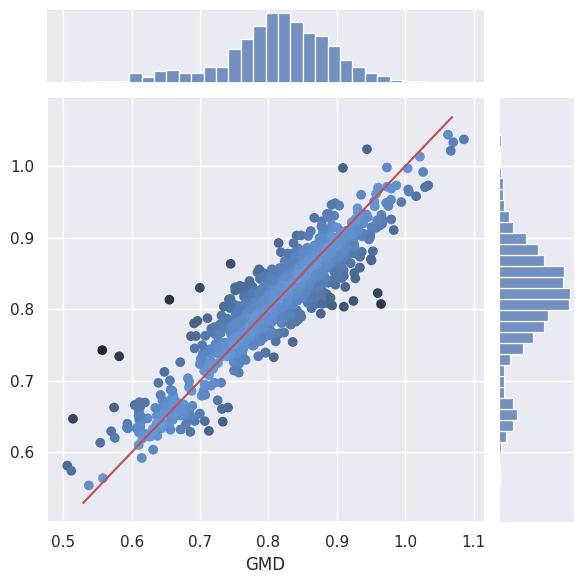

In [8]:
# Función para Graficar diferencias entre valor predicho y real en datos de test del modelo pasado
def graficoDiferencias(modelo, X_test_s, y_test):
    y_pred = modelo.predict(X_test_s)
    diferencia = abs(y_pred - y_test)
    g = sns.jointplot(x=y_test, y=y_pred)
    # Draw a line of x=y
    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, '-r')
    g.ax_joint.scatter(x=y_test, y=y_pred, c=diferencia.values, cmap=sns.dark_palette("#69d", reverse=True, as_cmap=True))
    plt.show()

# Graficar las diferencias
modelo = model # rs_cv.best_estimator_
#print('Score R2:',modelo.score(X_test_s, y_test))
graficoDiferencias(modelo, X_test_s, y_test)

In [9]:
### NO DA TIEMPO A TERMINAR ###

### Búscamos los mejores hiperparámetros (no da tiempo a buscar en Colab lo hago en local y guardo el mejor modelo)
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
np.random.seed(0)

rs_params = {
        'task': ['train'],
        'boosting_type': ['gbdt', 'dart', 'rf'],
        'objective': ['regression'],
        'num_leaves': [20, 31, 100, 500, 1000],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.4],
        'n_estimators': [50, 100, 200, 500, 1000, 1500],
        'num_boost_round': [20000],
        'early_stopping_rounds': [500],
        'verbose': [0]        
}

# Initialize a RandomizedSearchCV object using 5-fold CV-
rs_cv = RandomizedSearchCV(estimator=lgb.LGBMRegressor(), param_distributions=rs_params, cv=3, n_iter=200, scoring="neg_mean_squared_error", verbose=0, n_jobs=-1)

# Train on training data-
rs_cv.fit(X_train_s, y_train, eval_set=[(X_test_s, y_test)], eval_metric="rmse")

KeyboardInterrupt: ignored

Como en Colab tardaba mucho y terminaba abortando el proceso, decido hacerlo en mi PC local y guardar el mejor modelo obtenid con un R2=85%. 
Ahora veo de replicar los parámetros de ese mejor modelo bajo la optimización de hiperparámetros escogida y de entrenarlo en este cuaderno con aún más iteraciones.

In [50]:
# Definiendo parámetros del Modelo 
params = {
    'task': 'train', 
    'boosting': 'dart',
    'objective': 'regression',
    'num_leaves': 31,
    'learnnig_rate': 0.4,
    'metric': 'rmse',
    'n_estimators': 500,
    'verbose': -100
}

# Cargando Datos
lgb_train = lgb.Dataset(X_train_s, y_train, silent=True)
lgb_eval = lgb.Dataset(X_test_s, y_test, reference=lgb_train, silent=True)

# Ajustando el modelo
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 num_boost_round=20000,
                 verbose_eval=-100,
                 feature_name=list(x1.columns))
y_pred = model.predict(X_test_s)
mostrar_metricas(y_test, y_pred)

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: learnnig_rate
Metr.	 Valor			 Descripción
R^2 	 0.8417945814651489 	 (Coeficiente de Determinación)
RMSE	 0.001133644506063036 	 (Raíz de error cuadrático medio)
MAE 	 0.025451588780438125 	 (Error absoluto medio)
MAX 	 0.1922229409128967 	 (Error Máximo)


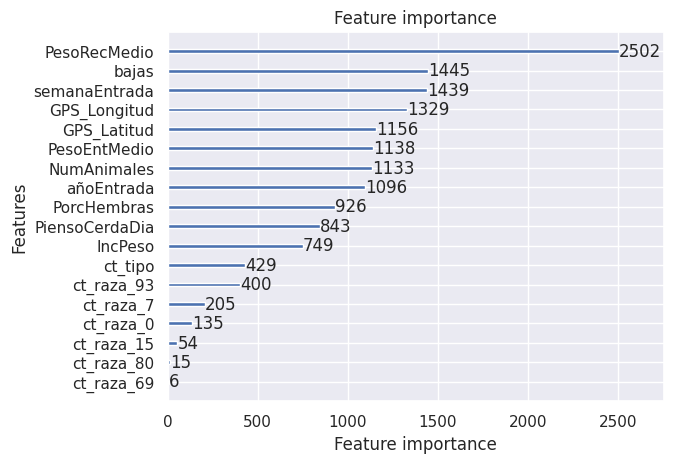

In [52]:
lgb.plot_importance(model)
plt.show()

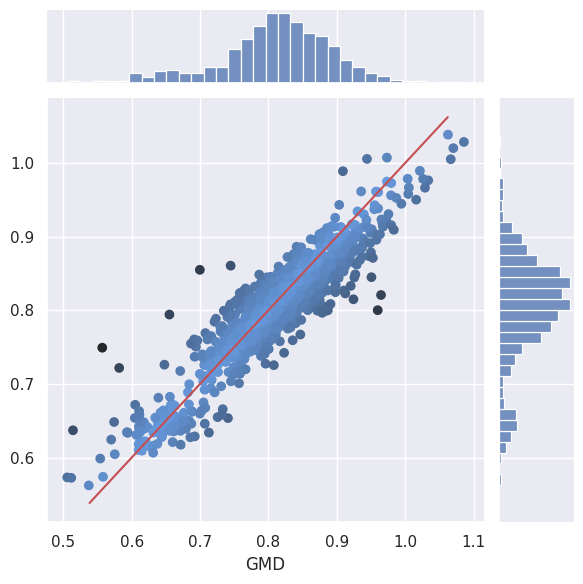

In [53]:
graficoDiferencias(model, X_test_s, y_test)

In [36]:
y_pred = model.predict(X_test_s)
mostrar_metricas(y_test, y_pred)

Metr.	 Valor			 Descripción
R^2 	 0.8417945814651489 	 (Coeficiente de Determinación)
RMSE	 0.001133644506063036 	 (Raíz de error cuadrático medio)
MAE 	 0.025451588780438125 	 (Error absoluto medio)
MAX 	 0.1922229409128967 	 (Error Máximo)


# Cargamos el modelo optimizado anteriormente

In [54]:
# Cargamos el fichero del modelo lightgbm.model.txt
uploaded = files.upload()
model2 = lgb.Booster(model_file='lightgbm.model.txt')

y_pred = model2.predict(X_test_s)
mostrar_metricas(y_test, y_pred)

Saving lightgbm.model.txt to lightgbm.model.txt
Metr.	 Valor			 Descripción
R^2 	 0.8506920300138257 	 (Coeficiente de Determinación)
RMSE	 0.0010698885123771175 	 (Raíz de error cuadrático medio)
MAE 	 0.024500069116363023 	 (Error absoluto medio)
MAX 	 0.1980376163023514 	 (Error Máximo)


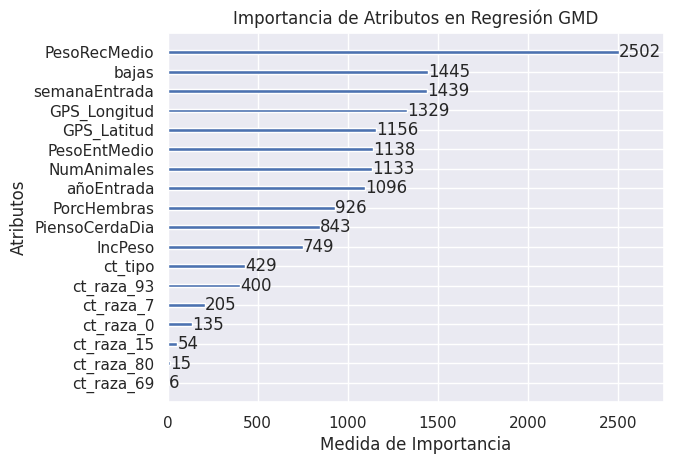

In [56]:
lgb.plot_importance(model)
plt.title('Importancia de Atributos en Regresión GMD')
plt.ylabel('Atributos')
plt.xlabel('Medida de Importancia')
plt.show()

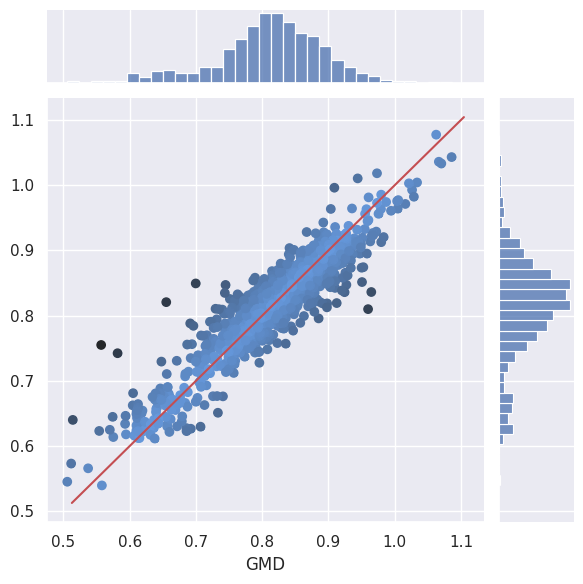

In [57]:
graficoDiferencias(model2, X_test_s, y_test)